# LSTM for Daily Minimum Temperature Prediction

# Overview

This is a daily minimum temperature forecast project using LSTM. The daily weather prediction using only a single variable without a physical model is an extremely difficult task. Therefore this project should be applicable to complex processes such as stock price forecast and other stochastic time series.

The codes for this project is modified from [Thushan Ganegedara's Datacamp tutorial](https://www.datacamp.com/community/tutorials/lstm-python-stock-market). 

# Background for LSTM
The long short-term memory (LSTM) unit is an improved version of gated recurrent unit (GRU), which tries to resolve the [vanishing gradient problem](http://neuralnetworksanddeeplearning.com/chap5.html) and keep the long term "memory" activated.

![alt text](LSTM_rnn.png "LSTM rnn")
![alt text](LSTM.png "LSTM cell")

* Picture summary ([Adrew Ng's lecture](https://www.coursera.org/specializations/deep-learning)):

> Four parallel layers of interacting networks.

> The weighted sum of the input and previous hidden output gets transformed by the activation functions (sigma (0 to 1) and tanh (-1 to 1)).  The `dot`/`add` signs represent elementwise `multiplication`/`addition`. 

> The cell state c[t] essentially stores the memory, which comes from multiplying the previous cell state to the `forgetness` (0 to 1). This essentially forgets/keeps the previous cell state if forgetness is near zero/one. 

> The activation/hidden state (last equation) is composed of current state `filter` (0 to 1) by the current cell state activation (-1 to 1) with previous memory. The hidden state connects to the ouput with softmax layer for prediction.

> Notice the [`peephole connection`](ftp://ftp.idsia.ch/pub/juergen/TimeCount-IJCNN2000.pdf), in other variation of LSTM, is not shown in the figure. It is done by adding another weighted sum of previous cell state c[t-1] to the forget and update gate, and add c[t] to the output gate. 


# Data 


Import the 10 years daily minimum temperature data:

In [91]:
import pandas as pd
series = pd.read_csv('~/Downloads/daily-minimum-temperatures-in-me.csv', error_bad_lines=False)
series.rename(columns={'Daily minimum temperatures in Melbourne, Australia, 1981-1990':'mint'},inplace=True) # rename minimum temp to 'mint'
y = pd.to_numeric(series["mint"],downcast='float')
y.index = pd.DatetimeIndex(start='1981-01-01',end='1990-12-31',freq='d')
freq=365 # sampling freq
train, valid = y[:freq*9], y[freq*9:]
train.index, valid.index = y.index[:freq*9], y.index[freq*9:]


A class to generate training data, i.e., batches of sequenced data for the input and output (set the random indexing distance for output time series to within 3 indices, this may be a reasonable guess from mid-latitude weather patterns):

In [92]:
import numpy as np
class DataGeneratorSeq(object):
    # series: total training time-series data
    # batch_size: the length of a batch/sequence
    # num_unroll: sampled number of batches/sequences
    # segments: total number of segments in a series that is divided by the batch_size
    
    def __init__(self,series,batch_size,num_unroll):
        self._series = series
        self._series_length = len(self._series) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._series_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._series_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._series[self._cursor[b]]
            batch_labels[b]= self._series[self._cursor[b]+np.random.randint(0,3)] 
            # draw one random index for the output within 3 indices
            

            self._cursor[b] = (self._cursor[b]+1)%self._series_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._series_length-1))



How does the training data batches look like? Set batchsize to 9 samples and 4 time steps, so it'll sample all the first 4 days in January and the prediction output is the randomly indexed (0-3 days) following days:

In [93]:
tstep = 4
batchsize = 9 # a batch contains the samples, not the dimensionality, so each input sample is fed forward once at a time to get an output
dg = DataGeneratorSeq(train,batchsize,tstep)
print('the first index of each batch: %s'%str(dg._cursor))
print('total number of segments: %d'%dg._segments)
print(dg._series.head(5))

u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutputs:',lbl)

the first index of each batch: [0, 364, 728, 1092, 1456, 1820, 2184, 2548, 2912]
total number of segments: 364
1981-01-01    20.700001
1981-01-02    17.900000
1981-01-03    18.799999
1981-01-04    14.600000
1981-01-05    15.800000
Freq: D, Name: mint, dtype: float32


Unrolled index 0
	Inputs:  [20.7 17.4 17.7 16.1 12.  13.3 10.5 11.2 15.2]

	Outputs: [18.8 17.  17.7 18.  16.  13.3 14.7 12.7 17.3]


Unrolled index 1
	Inputs:  [17.9 17.  16.3 20.4 12.6 11.5 14.7 12.1 17.3]

	Outputs: [17.9 13.5 18.4 19.5 12.6 11.5 14.2 12.1 19.8]


Unrolled index 2
	Inputs:  [18.8 15.  18.4 18.  16.  10.8 14.6 12.7 19.8]

	Outputs: [18.8 15.2 10.9 17.1 16.  12.  14.2 14.2  9.5]


Unrolled index 3
	Inputs:  [14.6 13.5 15.  19.5 16.4 12.  14.2 16.2 15.8]

	Outputs: [14.6 15.2 15.  19.5 16.4 16.3 14.2 14.3 12.9]


The `Unrolled index` is the timesteps, so 20.7, 17.9, 18.8, 14.6 is the four LSTM timesteps of `Inputs` fed forward. The associated four `Outputs` are the randomly indexed (within 0-3 days) four timesteps 20.7, 17.9, 18,8, 15.8. Notice the leading 3 steps of outputs were randomly sampled but identical to the leading 3 steps of the inputs.

In [94]:
import tensorflow as tf
D = 1 # Dimensionality/Feature of the data. Since the time-series is 1-D this would be 1
num_unrollings = 20 # Number of time steps you look into the future.
batch_size = 50 # Number of samples in a batch
num_nodes = [128,128,128] # Number of hidden nodes in each layer/cell of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

# Defining "tensorized" training data 

In [95]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

# Defining LSTM parameters

In [96]:
# Initialize LSTM cells with Xavier initializer. 
# Which sets small variance for the weights to avoid vanishing/exploding gradient problem 
# when using tanh as activation function
lstm_cells = [ tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
               for li in range(n_layers) ]

# dropout regularization is to reduce overfit (instead of waiting for backprop to find the near zero 
# weights for regularizatoin, dropout regularization draws a uniformly dist sample between 0 and 1 and 
# eliminate the nodes with probablity smaller than some keep_prob)
drop_lstm_cells = [ tf.contrib.rnn.DropoutWrapper(
                   lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout) 
                   for lstm in lstm_cells ]

# create the sequential RNN Cells with dropout regularization
multi_cell_drop = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)

# create the sequential RNN Cells without dropout regularization
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

# The output regression weights that transforms the final hidden layers of LSTM
w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))


# Defining batch sample multicell prediction: 

In [97]:
# Create cell state 'c' and hidden state 'h' variables for LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
    c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transformations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
# make input into a tensor of size [ntsteps, batch_size, D]
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0) 
print('Input tensor size [nt, batch_size, D]: '+str(all_inputs.shape))

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    multi_cell_drop, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)
print('LSTM hidden tensor size [nt, batch_size, hidden nodes]: '+str(all_lstm_outputs.shape))

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])
print('LSTM hidden tensor size reshaped [batch_size*nt, hidden nodes]: '+str(all_lstm_outputs.shape))

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)
print('Final output (w*LSTM_hidden_nodes + b) tensor size ' 
      '[batch_size*nt, hidden nodes]*[hidden nodes,1]=[batch_size*nt,1]: '+str(all_outputs.shape))

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)
print('Split final output into "nt" of [batch_size,1] tensors')

Input tensor size [nt, batch_size, D]: (20, 50, 1)
LSTM hidden tensor size [nt, batch_size, hidden nodes]: (20, 50, 128)
LSTM hidden tensor size reshaped [batch_size*nt, hidden nodes]: (1000, 128)
Final output (w*LSTM_hidden_nodes + b) tensor size [batch_size*nt, hidden nodes]*[hidden nodes,1]=[batch_size*nt,1]: (1000, 1)
Split final output into "nt" of [batch_size,1] tensors


# Loss and Optimizer
* Loss: sum through a batch of mean squared error between the true and prediction
* [Adam Optimizer](http://ruder.io/optimizing-gradient-descent/index.html#adam): gradient descent method with adaptive learning rate by [momentum](http://ruder.io/optimizing-gradient-descent/index.html#momentum) (accelerates/dampens in flat/steep gradients) and [RMSprop](http://ruder.io/optimizing-gradient-descent/index.html#rmsprop) (resolves radically decaying learning rate issue) with [learning rate decay](https://www.coursera.org/lecture/deep-neural-network/learning-rate-decay-hjgIA) (solidify convergence with increasing epochs).

In [98]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
    for ui in range(num_unrollings):
        loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


# Defining one-sample single cell prediction:

In [99]:
print('Defining 1-sample prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])
print('Input tensor size [1, D]: '+str(sample_inputs.shape))

# Maintaining LSTM state for prediction stage

# intialize LSTM tf variables
sample_c, sample_h, initial_sample_state = [],[],[] # cell state, hidden state, initial c h state
for li in range(n_layers):
    sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))


# assign: assign values to the tensors (c and h here)
# group: creates an operation that groups multiple operations
# a function to reset states to zeros
reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

# multi_cell: sequential RNN for LSTM defined previously
# expand_dims: Inserts a dimension of 1 into a tensor, so if x's dim is originally [2], expand_dims(x,0) becomes [1,2]
sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)
print('LSTM hidden tensor size [nt=1, batchsize=1, hidden nodes]: '+str(sample_outputs.shape))

# add ops dependencies to sample_prediction 
# (always assign an updated sample_state to c and h, which updates initial_sample_state, 
# before doing sample_prediction)
# a function for final output prediction 
with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
    sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)
print('Final output (w*LSTM_hidden_nodes + b) tensor size ' 
      '[1, hidden nodes]*[hidden nodes,1]=[1,1]: '+str(sample_prediction.shape))

print('\tAll done')

Defining 1-sample prediction related TF functions
Input tensor size [1, D]: (1, 1)
LSTM hidden tensor size [nt=1, batchsize=1, hidden nodes]: (1, 1, 128)
Final output (w*LSTM_hidden_nodes + b) tensor size [1, hidden nodes]*[hidden nodes,1]=[1,1]: (1, 1)
	All done


# Train and Predict
* Test set: define starting points (test_points_seq) on the time-series to test the model.
* 

In [100]:
train_data = train
all_data = np.concatenate([train,valid],axis=0)
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 10 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(365*9,365*9+300,10).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict) # output loss

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

        average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

        # The average loss
        print('Average loss at step %d: %f' % (ep+1, average_loss))

        train_mse_ot.append(average_loss)

        average_loss = 0 # reset loss

        predictions_seq = []

        mse_test_loss_seq = []

        # ===================== Updating State and Making Predicitons ========================
        for w_i in test_points_seq: # go through all the test points to generate the 10 days forecast
            mse_test_loss = 0.0
            our_predictions = []

            if (ep+1)-valid_summary==0:
                # Only calculate x_axis values in the first validation epoch
                x_axis=[]

            # Feed in the recent past behavior of series
            # to make predictions from that point onwards
            for tr_i in range(w_i-num_unrollings+1,w_i-1):
                current = all_data[tr_i]
                feed_dict[sample_inputs] = np.array(current).reshape(1,1)
                _ = session.run(sample_prediction,feed_dict=feed_dict)

            feed_dict = {}

            current = all_data[w_i-1]

            feed_dict[sample_inputs] = np.array(current).reshape(1,1)

            # Make predictions for this many steps
            # Each prediction uses previous prediciton as it's current input
            for pred_i in range(n_predict_once):
                
                pred = session.run(sample_prediction,feed_dict=feed_dict)

                our_predictions.append(np.asscalar(pred))

                feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

                if (ep+1)-valid_summary==0:
                  # Only calculate x_axis values in the first validation epoch
                  x_axis.append(w_i+pred_i)
                
                mse_test_loss += 0.5*(pred-all_data[w_i+pred_i])**2

            session.run(reset_sample_states)

            predictions_seq.append(np.array(our_predictions))

            mse_test_loss /= n_predict_once
            mse_test_loss_seq.append(mse_test_loss)

            if (ep+1)-valid_summary==0:
                x_axis_seq.append(x_axis)

        current_test_mse = np.mean(mse_test_loss_seq)

        # Learning rate decay logic
        if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
            loss_nondecrease_count += 1
        else:
            loss_nondecrease_count = 0

        if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

        test_mse_ot.append(current_test_mse)
        print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
        predictions_over_time.append(predictions_seq)
        print('\tFinished Predictions')

/usr/local/lib/python3.5/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Initialized
Average loss at step 1: 722.265653
	Test MSE: 12.05398
	Finished Predictions
Average loss at step 2: 165.815050
	Test MSE: 6.73725
	Finished Predictions
Average loss at step 3: 102.988166
	Test MSE: 4.85830
	Finished Predictions
Average loss at step 4: 87.690450
	Test MSE: 4.05882
	Finished Predictions
Average loss at step 5: 85.954015
	Test MSE: 3.85576
	Finished Predictions
Average loss at step 6: 82.747114
	Test MSE: 3.58692
	Finished Predictions
Average loss at step 7: 78.028744
	Test MSE: 4.37684
	Finished Predictions
Average loss at step 8: 76.759550
	Test MSE: 4.29752
	Finished Predictions
Average loss at step 9: 72.214300
	Decreasing learning rate by 0.5
	Test MSE: 3.65122
	Finished Predictions
Average loss at step 10: 69.360718
	Test MSE: 3.19774
	Finished Predictions
Average loss at step 11: 66.458300
	Test MSE: 3.42980
	Finished Predictions
Average loss at step 12: 64.699432
	Test MSE: 3.23193
	Finished Predictions
Average loss at step 13: 62.937620
	Decreasing l

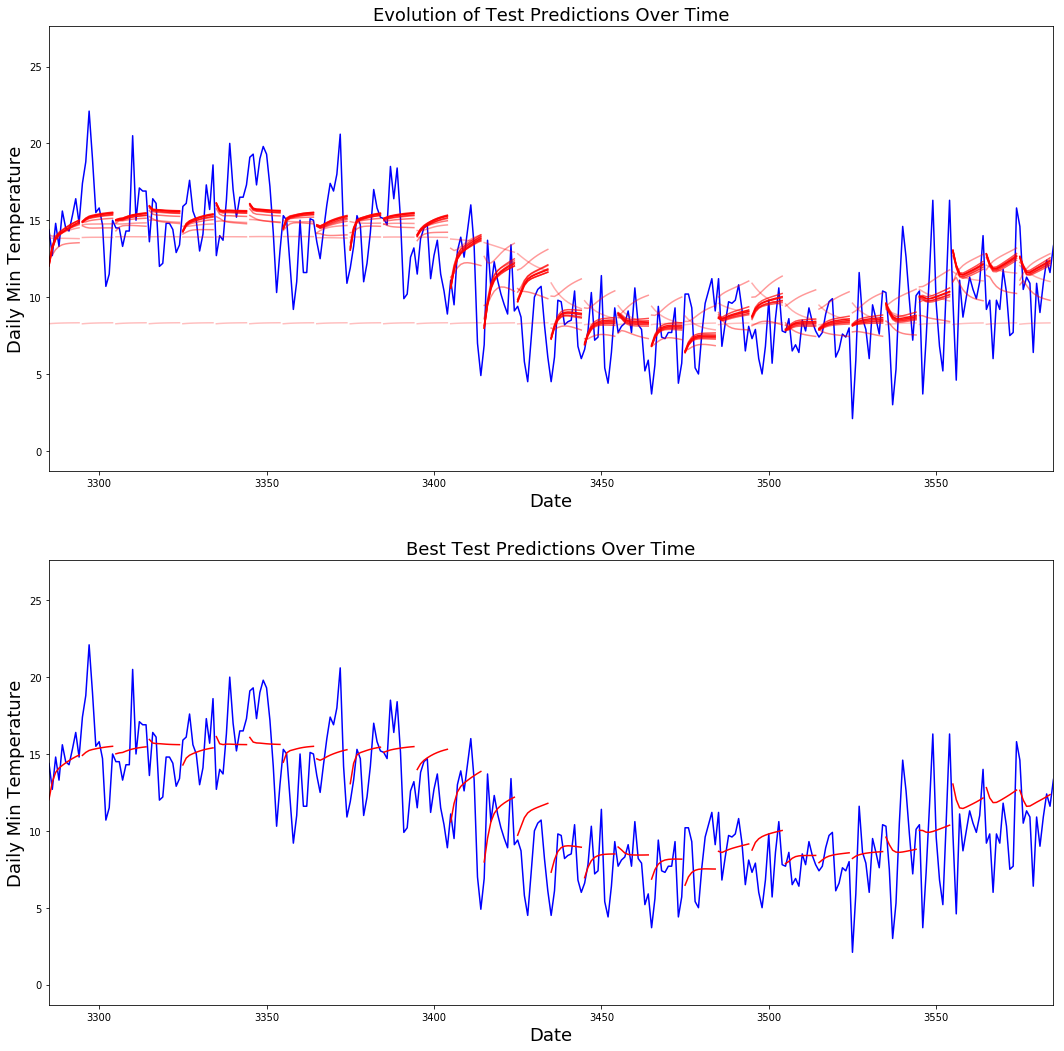

In [103]:
from matplotlib import pyplot as plt
from pandas import DataFrame as df
import time
best_prediction_epoch = 29 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(all_data,color='b')
#plt.show()
#time.sleep(10)
# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Daily Min Temperature',fontsize=18)
plt.xlim(365*9,365*9+300)


plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(all_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Daily Min Temperature',fontsize=18)
plt.xlim(365*9,365*9+300)
plt.show()

# Summary
The 10 days forecast of daily minimum temperature prediction shows pretty good match with the noisy day-to-day weather by using LSTM. There is no need to remove the seasonality or trend as ARIMA when forecasting with LSTM.

# Reference
* [Understanding LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [Why use LSTM? (paper collection)](http://people.idsia.ch/~juergen/rnn.html)
* [LSTM for stock prediction, referenece project](https://www.datacamp.com/community/tutorials/lstm-python-stock-market)
* [vanishing gradient problem explained](http://neuralnetworksanddeeplearning.com/chap5.html)